### Import Modules

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib nbagg

Simulation configuration

In [2]:
# Number of vehicles to keep track of, e.g. plot headways, positions of chosen vehicles
n_cars_plot = 4

Simulation configuration

In [3]:
# Number of vehicles to keep track of, e.g. plot headways, positions of chosen vehicles
n_cars_plot = 4

## Lane-Changing Models

In [4]:
def prob_enter(headway, vel, density, t_cur, t_lc, n_cars_cur, beta=2.820):
    """Probability of a car entering any of the gaps inbetween vehicles

    :returns: boolean array, True if a car enters a gap
                             False if a car does not enter the gap
    """
    
    th = headway #np.divide(headway,vel)  # time headway
    
    #mu_lc = 2.850 #1.9802 - 32.7937*density
    # 3.1 yield 10.973 cars over 45 runs! Perfect. 
    mu_lc = 3.09 #3.05 #2.98 #3
    sigma_lc = .3642
    
    mu_th = 2.9512 #2.05 - 48.53*density
    sigma_th = 0.4255
    
    # normalization constant
    C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
        * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
               (-2*sigma_th**2+2*sigma_lc**2)) \
        / np.sqrt(2*np.pi)
        
    p_appear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))
    
    #if (t_cur%t_lc)==0 and len(headway)<38:
    if (t_cur%t_lc)==0:
        #return np.random.rand(len(headway)) < p_appear * t_lc / beta
        return np.random.rand(len(headway)) < p_appear
    else:
        return [False]*len(headway)

In [5]:
def prob_exit(headway, vel, density, t_cur, t_lc, n_cars_cur, beta=2.82):
    """Probability of cars in the lane exitting

    :returns: boolean array, True if a car exits the lane
                             False if a car does not exit the lane
    """
    
    th = headway #np.divide(headway,vel)  # time headway
    
    mu_lc = 2.7962 #2.0718 - 51.96*density
    sigma_lc = 0.4176
    
    mu_th = 2.9512 #2.05 - 48.53*density
    sigma_th = 0.4255
    
    # normalization constant
    C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
        * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
               (-2*sigma_th**2+2*sigma_lc**2)) \
        / np.sqrt(2*np.pi)
        
    p_disappear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))
    
    #if (t_cur%t_lc)==0 and len(headway)>4:
    if (t_cur%t_lc)==0 and n_cars_cur > 2:
        #return np.random.rand(len(headway)) < p_disappear * t_lc / beta
        return np.random.rand(len(headway)) < p_disappear
    else:
        return [False]*len(headway)

## Car-Following Model

In [6]:
def car_following_OVM(y, t, params, y_minus_tau):
    """Defines car-following behavior of driver-vehicle units.
       Behvaior here is specified by the Optimal Velocity Model (OVM)
    
    :y: state of the system
        - first half of the array represents the headway of the cars, ordered in decreasing position
        - second half of the array represents the velocity of the cars, ordered as they are in the position half
    :t: time interval
    :params : parameters of the OVM car-following model
              - params['alpha']  : headway gain
              - params['beta']   : relative velocity gain
              - params['tau']    : driver reaction time [s]
              - params['v_max']  : maximum velocity [m/s]
              - params['h_go']   : go headway [m]
              - params['h_st']   : stop headway [m]
    :y_minus_tau: state of the system tau seconds ago
    
    :returns: dydt - derivative of the states (y)
    """
    
    dydt = np.zeros(len(y))
    n = int(len(y)/2)
    
    for i in range(n):
        if i==0:
            vl = y[-1]                      # velocity of lead vehicle
            vl_minus_tau = y_minus_tau[-1]  # lead velocity tau seconds ago
        else:
            vl = y[n+i-1]
            vl_minus_tau = y_minus_tau[n+i-1]
    
        v = y[n+i]                      # velocity of current vehicle
        h = y_minus_tau[i]              # headway of current vehicle
        v_minus_tau = y_minus_tau[n+i]  # velocity of current vehicle tau seconds ago
        
        if h <= params['h_st']:
            V = 0
        elif h < params['h_go']:
            V = params['v_max']/2*(1-np.cos(np.pi*(h-params['h_st'])/(params['h_go']-params['h_st'])))
        else:
            V = params['v_max']
            
        dydt[i] = vl - v
        dydt[n+i] = params['alpha']*(V-v_minus_tau) + params['beta']*(vl_minus_tau-v_minus_tau)
    
    return(dydt)

## Ring Road

In [7]:
class ring_road():
    """
    Simulation of vehicles in a circular lane following the IDM model.
    Vehicles are allowed to enter and exit the lane according to the probability "prob_enter" and "prob_exit"
    Certain vehicle units of your choosing can be held constant in the model for analysis purposes
    """
    
    def __init__(self, params, n_cars, x_init, v_init, ind_cars_const):
        """Instantiates the class with the car-following model parameters
           Initializes road with a set of vehicles with inital positions and velocities
           Specifies vehicles that should not be allowed to exit the road (may be equal to zero)
        
        :params         : parameters of the car-following model, MUST CONTAIN lr and lc
                           - params['lc'] : average vehicle length [m]
                           - params['lr'] : length of the circular road [m]
        :n_cars         : initial number of cars on the road [unitless]
        :x_init         : inital position of each car in the set [m]
        :v_init         : initial velocity of each car in the set [m/s]
        :ind_cars_const : index of cars in the set that should be held constant (length equal to n_cars_const)
        """
        # car-following parameters
        self.params = params
        
        # parameters that are crucial for simulation
        self.lc  = params['lc']
        self.lr  = params['lr']
        self.tau = params['tau']
        
        # initial conditions of vehicles
        self.n_cars = n_cars
        self.x_init = x_init
        self.v_init = v_init
        self.h_init = np.append(-(x_init[-1]-x_init[0])+params['lr'], x_init[1:]-x_init[:-1]) - params['lc']
        
        # cars that cannot exit the road
        self.ind_cars_const = ind_cars_const
    
    
    def simulate(self, dt, t_final, t_lc=0):
        if t_lc == 0:
            t_lc = dt
        n_cars_const = len(self.ind_cars_const)
        
        # initialize empty dataframe to collect lane-change data
        lane_change_df = pd.DataFrame(columns=('time', 'velocity', 'lead_velocity', 'lag_velocity',
                                               'distance_headway', 'type'))
        
        # store constant cars in the first n columns
        ind_variable_cars = np.arange(self.n_cars)
        ind_variable_cars = ind_variable_cars[np.invert(np.in1d(ind_variable_cars,self.ind_cars_const))]
        ind = np.append(self.ind_cars_const, ind_variable_cars).astype(int)
        
        # reorganize inital conditions given new index arrangement
        y0 = np.append(self.h_init[ind], self.v_init[ind])
        
        # time range from 0 to t_final
        t = np.arange(0, t_final+dt, dt)
        
        # initialize variables of interest
        pos = np.zeros((len(t), int(len(y0)/2)))
        pos[0,:] = self.x_init
        sol = np.zeros((len(t), len(y0)))
        sol[0,:] = y0
        num_exits = np.zeros(len(t))
        num_enters = np.zeros(len(t))
        
        n_cars_tot = self.n_cars  # total number of cars to be in the lane
        n_cars_cur = np.append(self.n_cars, np.zeros(len(t)-1))  # current number of cars in the lane
        ind_cars = np.arange(self.n_cars)
        ind_cars = ind_cars[np.argsort(self.x_init[ind])][::-1]  # indeces of the cars currently in the lane
                                                                 # organized in decreasing order of position
        
        for i in range(1,len(t)):
            ########## calculate next position and velocity of current cars in lane ##########
            sol_i = odeint(car_following_OVM, sol[i-1, np.append(ind_cars, ind_cars+n_cars_tot)], [0,dt],
                           args=(self.params,sol[max(0,i-int(self.tau/dt)), np.append(ind_cars, ind_cars+n_cars_tot)]))
            
            # store new position and velocity data
            # set negative velocities to zero
            sol[i,np.append(ind_cars, ind_cars+n_cars_tot)] = sol_i[-1,:]
            # the minus 1e-12 lets us distinguish between speeds that are being set to negative
            # and terms in the array that are zero because the car isn't there anymore
            sol[i,:] = sol[i,:].clip(min=-1e-12)
            
            # headway of each car currently in the lane
            headway_cur = sol[i, ind_cars]
            
            # velocity of each car currently in the lane
            vel_cur = sol[i, ind_cars+n_cars_tot]
            
            # failsafe velocity
            max_deacc = 5
            d = -headway_cur - np.square(np.append(vel_cur[-1:],vel_cur[:-1]))/(2*max_deacc)
            v_failsafe = -max_deacc*self.tau + np.sqrt(max_deacc)*np.sqrt(-2*d + max_deacc*self.tau**2)
            sol[i,ind_cars+n_cars_tot] = sol[i,ind_cars+n_cars_tot].clip(max=v_failsafe)
            
            # store new headway data
            pos[i,ind_cars] = pos[i-1,ind_cars]+vel_cur*dt
            
            
            ######## check for situations of lane changes given velocity and headway #########            
            
            # density of lane
            density = 0.02# n_cars_cur[i-1]/self.lr
                        
            # determine which gaps accept new cars
            enter = prob_enter(headway_cur, vel_cur, density, t[i], t_lc, n_cars_cur[i-1])
            # determine which cars exit the lane
            exit = prob_exit(headway_cur, vel_cur, density, t[i], t_lc, n_cars_cur[i-1])
            # ensure that cars that are constant do not exit the lane
            exit = np.logical_and(exit, np.logical_not(np.in1d(ind_cars,np.arange(n_cars_const))))
            num_exits[i] = sum(exit)
            num_enters[i] = sum(enter)
            
            
            ################### collect exit data in lane-change dataframe ###################
            
            if sum(exit)>0:
                ind_exit = np.where(exit)[0]
                
#                 if exit[-1]:
#                     # add headways to lagging vehicle of exitted vehicles
#                     sol[i, np.append(ind_cars[ind_exit[:-1]+1],ind_cars[0])] += sol[i, ind_cars[ind_exit]]
#                 else:
#                     # add headways to lagging vehicle of exitted vehicles
#                     sol[i, ind_cars[ind_exit+1]] += sol[i, ind_cars[ind_exit]]
                # add headways to lagging vehicle of exitted vehicles
                for j in range(len(ind_exit)):
                    if ind_cars[ind_exit[j]] == ind_cars[-1]:
                        sol[i,ind_cars[0]] += sol[i, ind_cars[ind_exit[j]]]
                    else:
                        sol[i,ind_cars[ind_exit[j]+1]] += sol[i, ind_cars[ind_exit[j]]]
            
            
            ############## update variables given cars that entered and/or exit ##############
            
            if sum(enter)>0:
                ind = np.where(enter)[0]
                
                # calculate the velocity of the new vehicle ()
                v_new = sol[i, ind_cars[ind]+n_cars_tot]
                
                # calculate the headway of the new vehicle and the vehicle behind it
                h_new = 0.5*sol[i, ind_cars[ind]]
                h_lag_new = sol[i, ind_cars[ind]] - h_new
                
                # calculate the position of the new vehicles
                pos_new = pos[i, ind_cars[ind]]+h_lag_new

                # add columns to sol to compensate for the presence of new vehicles
                sol = np.insert(sol, [n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
                sol = np.insert(sol, [sum(enter)+n_cars_tot+n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
                
                # Don't update the history in the past
                # add initial data of new vehicles into sol
#                 sol[i, np.arange(sum(enter))+n_cars_const] = h_new
#                 sol[i, np.arange(sum(enter))+n_cars_tot+sum(enter)+n_cars_const] = v_new
                
                # Update the history in the past
                for j in np.arange(i-int(self.tau/dt),i+1):
                    h_new = 0.5*sol[j, ind_cars[ind]]
                    sol[j, ind_cars[ind]] = h_new 
                    sol[j,np.arange(sum(enter))+n_cars_const] = h_new
                    sol[j,np.arange(sum(enter))+n_cars_tot+sum(enter)+n_cars_const] = v_new
                # add columns to position to compensate for the presence of new vehicles
                pos = np.insert(pos, [n_cars_const], np.zeros((pos.shape[0], sum(enter))), axis=1)
                
                # update data in headway matrix to account for changes
                pos[i, np.arange(sum(enter))+n_cars_const] = pos_new
            
            # update indeces (whether change occured or not), and add cars (if change occured)
            exit = np.logical_or(exit, np.in1d(ind_cars,np.arange(n_cars_const)))
            ind_cars = np.append(np.append(np.arange(n_cars_const), np.arange(sum(enter))+n_cars_const),
                                 ind_cars[np.invert(exit)]+sum(enter))
            # order the indeces by position
            ind_cars = ind_cars[np.argsort(pos[i, ind_cars])[::-1]]
            
            n_cars_tot += sum(enter)
            n_cars_cur[i] = n_cars_cur[i-1] + sum(enter) - sum(exit) + n_cars_const
            
            
        pos_rad = np.divide(pos, self.lr) * 2*np.pi  # position in terms of radians
        pos_absolute = pos  # absolute position of every car, in meters
        headway = sol[:,:int(sol.shape[1]/2)]  # headway of every cars at every point in time
        vel = sol[:,int(sol.shape[1]/2):]  # velocity of every cars at every point in time, 0 if car is not avaialable
        
        return(pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur, num_exits, num_enters)

# Main

## Initialization

In [8]:
# define parameters of interest for the car following model
params = {'alpha':0.6, 'beta':0.9, 'tau':0.4, 'v_max':30, 'h_go':35, 'h_st':5, 'lc':0, 'lr':230}

# specify initial conditions
n_cars = 11  # number of cars
x_init = t = np.linspace(0, float(params['lr'])-float(params['lr'])/n_cars, n_cars)  # initial position of cars
v_init = 10*np.ones(n_cars)  # initial velocity of cars

# indeces of cars that do not change lanes
ind_cars_const = np.array([])

# initialize model
model = ring_road(params, n_cars, x_init, v_init, ind_cars_const)

# Simulation

In [11]:
dt = 0.025    # update time [s]
t_final = 2000  # simulation time [s]
lane_change_step = 2

## begin simulation
t1 = time.time()
# try changing r_lc to .5
pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur, num_exits, num_enters = model.simulate(dt, t_final, t_lc=lane_change_step)
t2 = time.time()

print("Simulation Time:", t2-t1)
print("Avg car num:", np.average(n_cars_cur))
print("Avg velocity:", np.average(np.sum(vel, axis=0)/np.sum(vel!=0, axis=0)))
print("Total lane-change", np.sum(num_exits) + np.sum(num_enters))

Simulation Time: 56.277337074279785
Avg car num: 11.6459919251
Avg velocity: 13.732896039
Total lane-change 214.0


## Avg Number of Car Calibration

In [13]:
dt = 0.025    # update time [s]
t_final = 900  # simulation time [s]
lane_change_step = 2
num_runs = 100
avg_car_num = np.zeros(num_runs)
avg_vel = np.zeros(num_runs)
avg_lc = np.zeros(num_runs)
## begin simulation
for i in range(num_runs):
    print(i)
    t1 = time.time()
    # try changing r_lc to .5
    pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur, num_exits, num_enters = model.simulate(dt, t_final, t_lc=lane_change_step)
    t2 = time.time()
    avg_car_num[i] = np.average(n_cars_cur)
    avg_vel[i] = np.average(np.sum(vel, axis=0)/np.sum(vel!=0, axis=0))
    avg_lc[i] = np.sum(num_exits) + np.sum(num_enters)

print("Simulation Time:", t2-t1)
print(avg_vel)
print("Avg velocity:", np.average(avg_vel))
print(avg_car_num)
print("Avg car num over runs:", np.average(avg_car_num))
print("Average number of lane changes:", np.average(avg_lc))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Simulation Time: 20.838309049606323
[ 16.02217065  16.86029938  18.63033874  15.72753371  16.10612709
  23.03228784  14.59076726  16.67920077  14.49554908  22.12731516
  17.4982295   17.75394264  18.33623962  19.27439324  16.72665887
  19.00709471  17.70890178  16.73989255  19.60901053  15.19486011
  13.61982995  17.41301346  15.47001173  18.58275135  17.19180176
  15.56711211  16.38537551  18.97843573  16.49546558  18.2467416
  18.62587933  18.66478206  16.64986045  16.60331946  19.70092029
  20.10163384  19.14969633  17.74350188  15.09761462  15.37974063
  15.78886575  15.06656612  17.68632411  16.19340704  14.64228018
  22.78910037  17.83503381  16.45067057  17.479861    19.5347074
  17.32423106  1

## Visualization

### Video

<IPython.core.display.Javascript object>


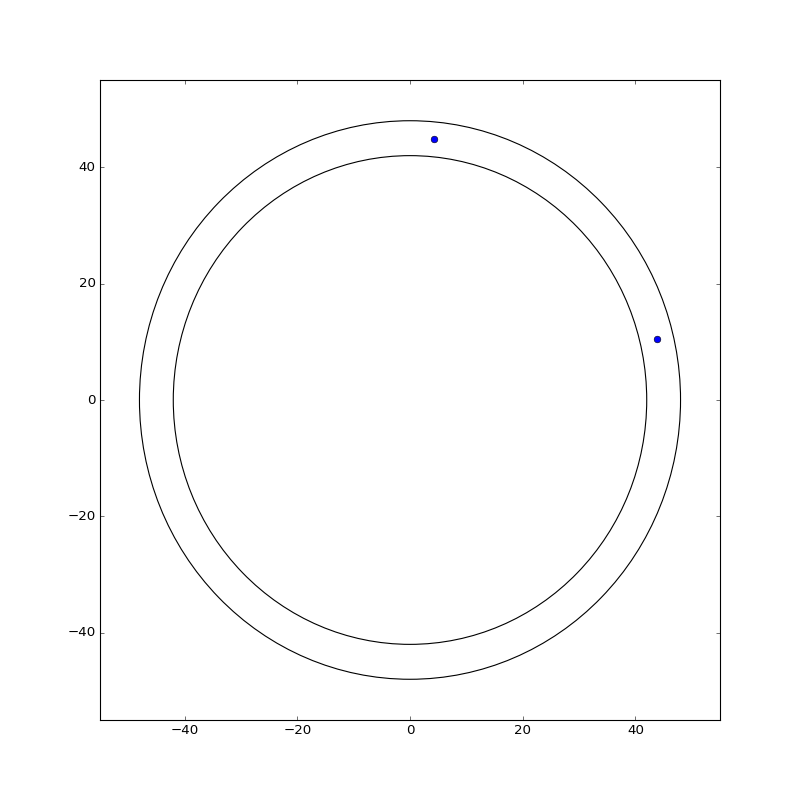

In [34]:
import time

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# initial x and y data
x = 45 * np.cos(pos_rad)
y = 45 * np.sin(pos_rad)

li1, = ax.plot(x[0,4:], y[0,4:], 'o')
li2, = ax.plot(x[0,:4], y[0,:4], 'o', c='r')

# draw circular road
circle1 = plt.Circle((0, 0), 42, color='k', fill=False)
circle2 = plt.Circle((0, 0), 48, color='k', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)

# draw and show it
fig.canvas.draw()
plt.xlim([-55,55])
plt.ylim([-55,55])
plt.show(block=False)

# loop to update the data
for i in range(76000,78000,10):
    # set the new data
    li1.set_xdata(x[i,pos_rad[i,:]!=0])
    li1.set_ydata(y[i,pos_rad[i,:]!=0])
    li2.set_xdata(x[i,pos_rad[i,:len(model.ind_cars_const)]!=0])
    li2.set_ydata(y[i,pos_rad[i,:len(model.ind_cars_const)]!=0])
    
    fig.canvas.draw()
    #time.sleep(0.05)

### Position Profile (Time-space diagram)

In [ ]:
pos_absolute.shape

In [15]:
# Plot all cars at once, but for a snippet of the overall simulation run
step_min, step_max = 0, 1000  # start
# step_min, step_max = 19000, 20000  # end

t = np.arange(0, t_final+dt, dt)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# i is each vehicle that ever exists in the simulation
for i in range(int(pos_absolute.shape[1])):
    valid_ind = pos_absolute[step_min:step_max,i]!=0
    plt.plot(t[step_min:step_max][valid_ind], pos_absolute[step_min:step_max,:][valid_ind][:,i])

li1, = ax.plot(x[0,4:], y[0,4:], 'o')
li2, = ax.plot(x[0,:4], y[0,:4], 'o', c='r')

# draw circular road
circle1 = plt.Circle((0, 0), 42, color='k', fill=False)
circle2 = plt.Circle((0, 0), 48, color='k', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)

# draw and show it
fig.canvas.draw()
plt.xlim([-55,55])
plt.ylim([-55,55])
plt.show(block=False)

# loop to update the data
for i in range(1,x.shape[0],10):
    # set the new data
    li1.set_xdata(x[i,pos_rad[i,:]!=0])
    li1.set_ydata(y[i,pos_rad[i,:]!=0])
    li2.set_xdata(x[i,pos_rad[i,:len(model.ind_cars_const)]!=0])
    li2.set_ydata(y[i,pos_rad[i,:len(model.ind_cars_const)]!=0])
    
    fig.canvas.draw()
    #time.sleep(0.05)

<IPython.core.display.Javascript object>

NameError: name 'x' is not defined

### Headway Profile (Convergence plot)

<IPython.core.display.Javascript object>


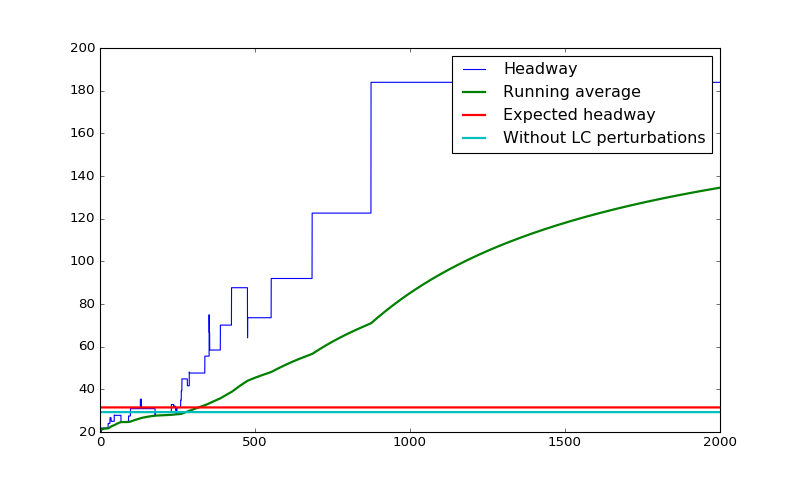

<IPython.core.display.Javascript object>


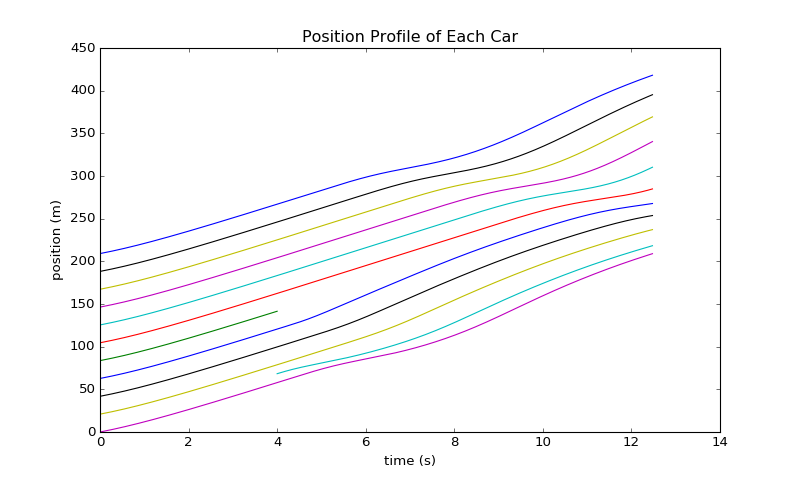

headway is  (80001, 22)


<IPython.core.display.Javascript object>


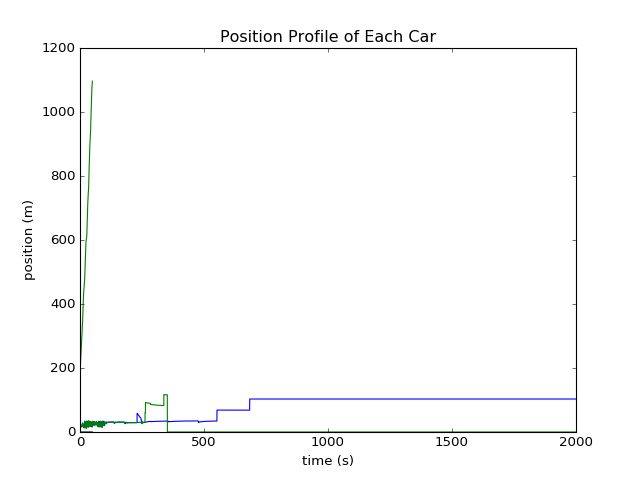

<IPython.core.display.Javascript object>


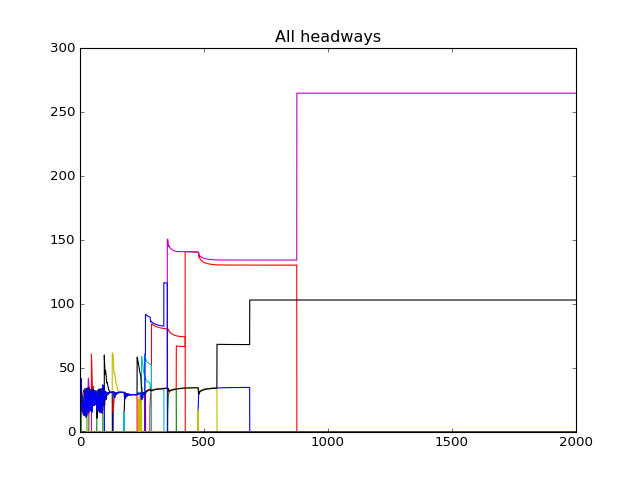

In [36]:
# Plot all cars at once, but for a snippet of the overall simulation run
step_min = 0
step_max = 500
t = np.arange(0, t_final+dt, dt)

# calculate average headway
avg_headway = np.zeros(headway.shape[0])
convg_headway = np.zeros(headway.shape[0])

for i in range(avg_headway.shape[0]):
    avg_headway[i] = np.sum(headway[i,:])/sum(headway[i,:]!=0)
    convg_headway[i] = np.average(avg_headway[0:i])
    
plt.figure(figsize=(10,6))

plt.plot(t[avg_headway!=0], avg_headway[avg_headway!=0], label="Headway")
plt.plot(t[convg_headway!=0], convg_headway[convg_headway!=0], label='Running average', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 31.5199, 'r', label='Expected headway', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 230 / 7.8449, 'c', label='Without LC perturbations', linewidth=2)

plt.legend(loc=1)
plt.figure(figsize=(10,6))

# i is each vehicle that ever exists in the simulation
for i in range(int(pos_absolute.shape[1])):
    valid_ind = pos_absolute[step_min:step_max,i]!=0
    plt.plot(t[valid_ind], pos_absolute[valid_ind][:,i])

plt.title("Position Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

select_headway = [20, 21]
print('headway is ', headway.shape)
plt.figure()
for i in range(len(select_headway)):
    plt.plot(t, headway[:, select_headway[i]])
    
# i is each vehicle that ever exists in the simulation
for i in range(int(pos_absolute.shape[1])):
    valid_ind = pos_absolute[76000:78000,i]!=0
    plt.plot(t[valid_ind], pos_absolute[valid_ind][:,i])

plt.title("Position Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

plt.figure()
for i in range(headway.shape[1]):
    plt.plot(t, headway[:, i])
plt.title("All headways")

### Headway Profile (Convergence plot)

In [ ]:
print("Average number of cars (nbar):", np.average(n_cars_cur))
# TODO compute the equilibrium headway and velocity at nbar
print("h_nbar^*:")
print("v_nbar^*:")

### Velocity Profile

17.2096403702


<IPython.core.display.Javascript object>


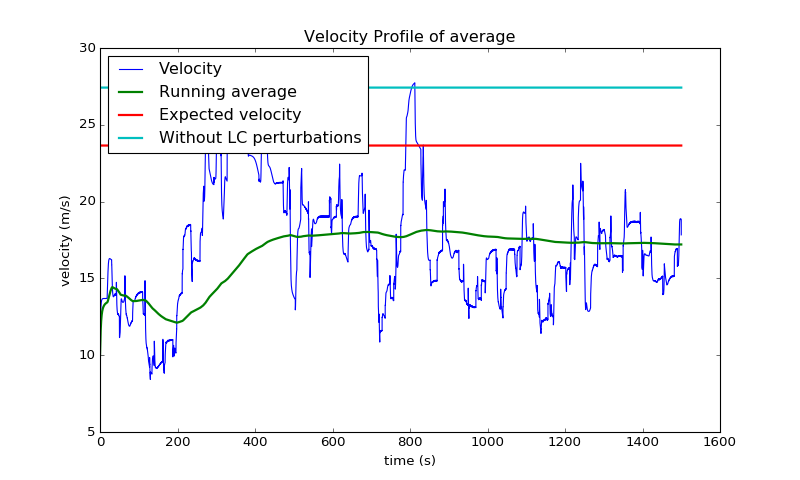

<IPython.core.display.Javascript object>


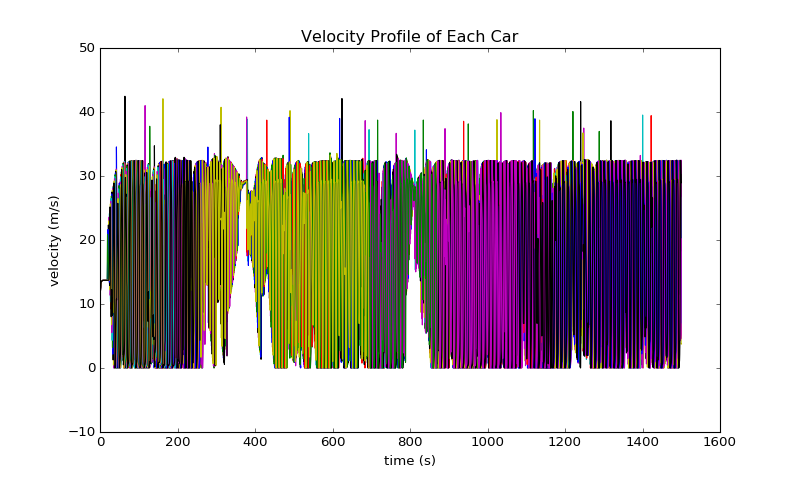

<IPython.core.display.Javascript object>


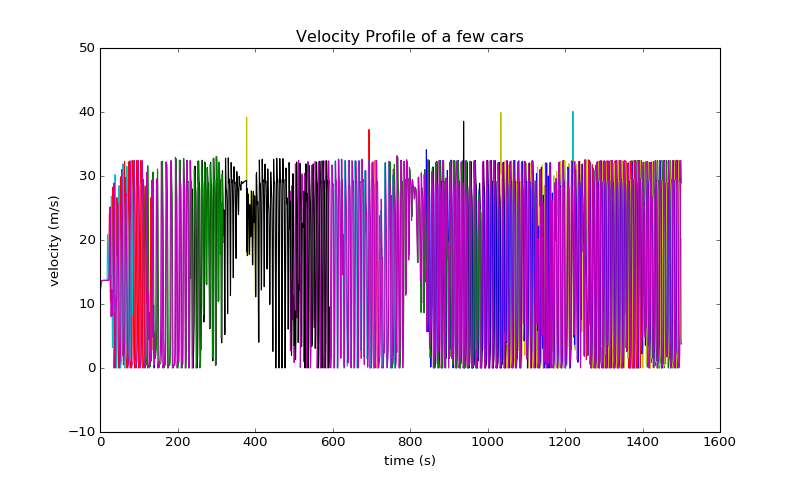

6.87174967499
16.838672422
16.9972260206
17.3986849366
13.0804166411
16.1486567676
14.2353863392
15.9308506851
17.9993612489
14.8652914288
16.9487659947
16.8210339488
22.5132763295
21.2808787023
4.02820146828
15.6117585347
13.0663044951
13.9224677196
12.7521264607


In [11]:
t = np.arange(0, t_final+dt, dt)

avg_vel = np.zeros(vel.shape[0])
convg_vel = np.zeros(vel.shape[0])
for i in range(avg_vel.shape[0]):
    avg_vel[i] = np.sum(vel[i,:])/sum(vel[i,:]!=0)
    convg_vel[i] = np.average(avg_vel[0:i])

print(convg_vel[-1])
plt.figure(figsize=(10,6))
plt.plot(t[avg_vel!=0], avg_vel[avg_vel!=0], label="Velocity")
plt.plot(t[convg_vel!=0], convg_vel[convg_vel!=0], label='Running average', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 16.6384, 'r', label='Expected velocity', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 16.304, 'c', 
         label='Without LC perturbations', linewidth=2)

plt.legend(loc=2)
plt.title("Velocity Profile of average")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()    
    
plt.figure(figsize=(10,6))

for i in range(vel.shape[1]):
    plt.plot(t[vel[:,i]!=0], vel[vel[:,i]!=0,i])

plt.title("Velocity Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')

# Plot a few representative trajectories
plt.figure(figsize=(10,6))

np.set_printoptions(threshold=np.nan)
for i in range(vel.shape[1]):
    if i%5==0:
        plt.plot(t[vel[:,i]!=0], vel[vel[:,i]!=0,i])
        print(np.sum(vel[:,i])/np.sum(vel[:,i]!=0))

plt.title("Velocity Profile of a few cars")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')

plt.show()

### Number of Cars vs. Time

11.646


<IPython.core.display.Javascript object>


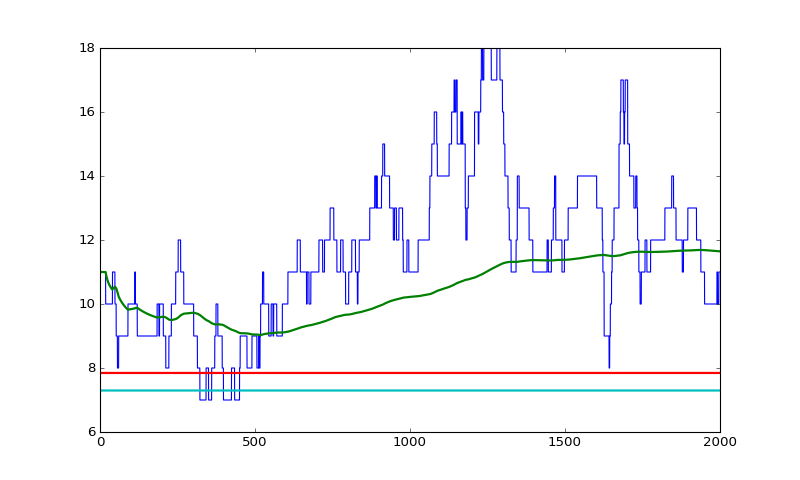

In [12]:
t = np.arange(0, t_final+dt, dt)


# calculate the average number of cars over time
avg_cars = np.zeros(n_cars_cur.shape[0])
for i in range(avg_cars.shape[0]):
    avg_cars[i] = np.average(n_cars_cur[0:i])
    
print(avg_cars[-1])  


plt.figure(figsize=(10,6))

plt.plot(t,n_cars_cur, label='Number of cars')
plt.plot(t,avg_cars, label='Running average', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 7.8449, 'r', label='Expected number of cars', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 230 / (31.5199 + params['lc']), 'c', 
         label='Without LC perturbations', linewidth=2)

# max occupancy is over 160, I recommend not putting
#plt.plot(t,max_occupancy*np.ones(len(t)))

#plt.legend()

#plt.title("Number of Cars vs. Time")
#plt.xlabel('time (s)')

#for i in range(headway.shape[1]):
#    plt.plot(t[headway[:,i]!=0], headway[headway[:,i]!=0][:,i])

#plt.title("Headway Profile of Selected Cars")
#plt.xlabel('time (s)')
#plt.ylabel('headway (m)')
plt.show()

## Number of Lane Changes

<IPython.core.display.Javascript object>


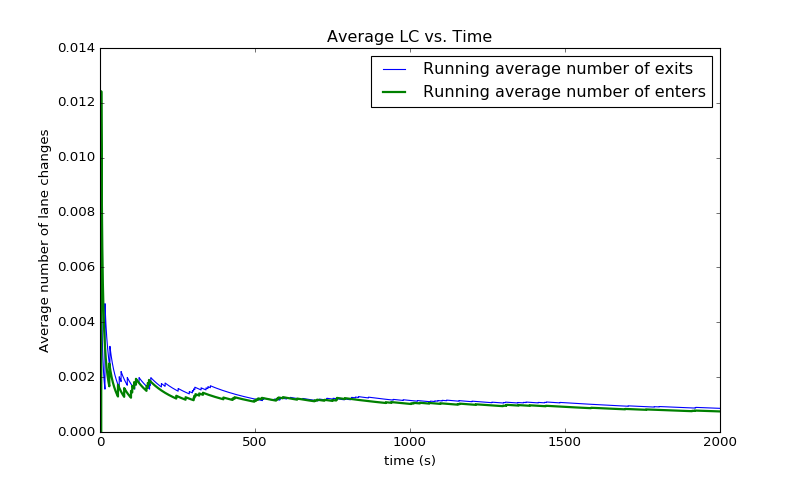

<IPython.core.display.Javascript object>


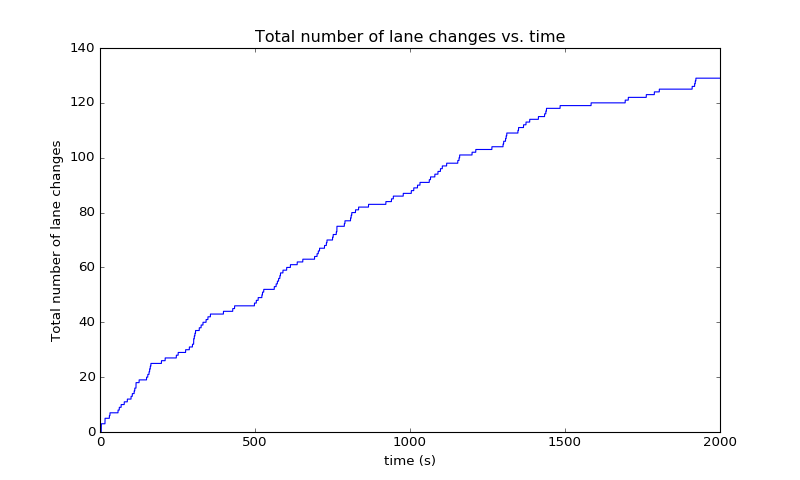

<IPython.core.display.Javascript object>


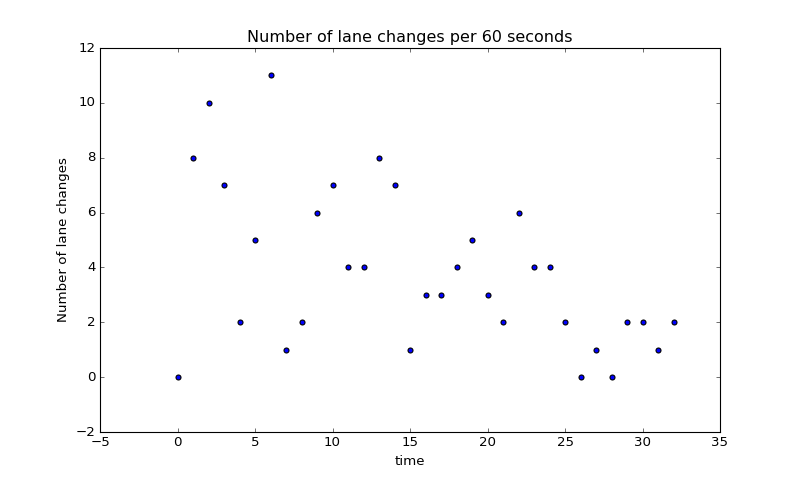

129.0


In [20]:
t = np.arange(0, t_final+dt, dt)

# calculate the average number of lane changes
avg_exits = np.zeros(n_cars_cur.shape[0])
avg_enters = np.zeros(n_cars_cur.shape[0])
total_lc = np.zeros(n_cars_cur.shape[0])
unit = 60; 
lc_per_min = np.zeros(np.floor(len(t)/(unit/dt)))
for i in range(len(t)):
    avg_exits[i] = np.average(num_exits[0:i])
    avg_enters[i] = np.average(num_enters[0:i])
    total_lc[i] = np.sum(num_enters[0:i]) + np.sum(num_exits[0:i])

plt.figure(figsize=(10,6))
plt.plot(t,avg_exits, label='Running average number of exits')
plt.plot(t,avg_enters, label='Running average number of enters', linewidth=2)
plt.legend()
plt.title("Average LC vs. Time")
plt.xlabel('time (s)')
plt.ylabel('Average number of lane changes')

plt.figure(figsize=(10,6))
plt.plot(t, total_lc)
plt.title('Total number of lane changes vs. time')
plt.xlabel('time (s)')
plt.ylabel('Total number of lane changes')

# plot lane changes per minute
min_step = int(np.floor(unit/dt))
for i in range(int(np.floor(len(t)/(unit/dt)))):
    lc_per_min[i] = np.sum(num_enters[(i-1)*min_step:i*min_step]) + np.sum(num_exits[(i-1)*min_step:i*min_step])
    
plt.figure(figsize=(10,6))
plt.scatter(range(int(np.floor(len(t)/(unit/dt)))), lc_per_min)
plt.title('Number of lane changes per {0} seconds'.format(unit))
plt.xlabel('time')
plt.ylabel('Number of lane changes')

plt.show()
print(total_lc[-1])